In [1]:
import os
import numpy as np
import shutil
import glob
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm import tqdm
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:21:00.0, compute capability: 8.6



In [2]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
train_files = glob.glob('./data/pets_images/train/*.jpg')
test_files = glob.glob('./data/pets_images/test/*.jpg')
validation_files = glob.glob('./data/pets_images/validation/*.jpg')

train_images = []; train_labels = []
test_images = []; test_labels = []
validation_images = []; validation_labels = []

for file in tqdm(train_files):
    img = load_img(file)
    img = img_to_array(img)
    train_images.append(img)
    if 'cat' in file:
        train_labels.append(0)
    else:
        train_labels.append(1)

for file in tqdm(test_files):
    img = load_img(file)
    img = img_to_array(img)
    test_images.append(img)
    if 'cat' in file:
        test_labels.append(0)
    else:
        test_labels.append(1)
        
for file in tqdm(validation_files):
    img = load_img(file)
    img = img_to_array(img)
    validation_images.append(img)
    if 'cat' in file:
        validation_labels.append(0)
    else:
        validation_labels.append(1)
        
train_images = np.array(train_images)
test_images = np.array(test_images)
validation_images = np.array(validation_images)

100%|██████████| 3751/3751 [00:28<00:00, 130.28it/s]


In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   zoom_range=0.3, 
                                   rotation_range=50,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=30)
validation_generator = validation_datagen.flow(validation_images, validation_labels, batch_size=20)

In [16]:
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

input_shape = (150, 150, 3)

vgg = VGG16(include_top=False, weights='imagenet',input_shape=input_shape)

vgg.trainable = False
for layer in vgg.layers[:-8]:
    layer.trainable = False

vgg_output = vgg.layers[-1].output

head_model = Flatten()(vgg_output)
head_model = Dense(512, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)

head_model = Dense(512, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)

output = Dense(1, activation='sigmoid')(head_model)
model = Model(vgg.input, output)


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])


model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [17]:
import pandas as pd
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])     

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_3,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False


In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

filepath = "model/vgg_transfer_learn_dogvscat_2.h5"

save_model_cb = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
# callback to stop the training if no improvement
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min')

callbacks_list = [save_model_cb, early_stopping_cb]

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=validation_generator, validation_steps=50,
                              verbose=2, callbacks=callbacks_list)

Epoch 1/100
100/100 - 14s - loss: 0.5971 - accuracy: 0.6770 - val_loss: 0.3727 - val_accuracy: 0.8380

Epoch 00001: val_accuracy improved from -inf to 0.83800, saving model to model\vgg_transfer_learn_dogvscat_2.h5
Epoch 2/100
100/100 - 13s - loss: 0.4690 - accuracy: 0.7723 - val_loss: 0.3260 - val_accuracy: 0.8640

Epoch 00002: val_accuracy improved from 0.83800 to 0.86400, saving model to model\vgg_transfer_learn_dogvscat_2.h5
Epoch 3/100
100/100 - 13s - loss: 0.4560 - accuracy: 0.7787 - val_loss: 0.2908 - val_accuracy: 0.8700

Epoch 00003: val_accuracy improved from 0.86400 to 0.87000, saving model to model\vgg_transfer_learn_dogvscat_2.h5
Epoch 4/100
100/100 - 14s - loss: 0.4321 - accuracy: 0.7970 - val_loss: 0.3098 - val_accuracy: 0.8600

Epoch 00004: val_accuracy did not improve from 0.87000
Epoch 5/100
100/100 - 13s - loss: 0.4310 - accuracy: 0.8003 - val_loss: 0.3692 - val_accuracy: 0.8360

Epoch 00005: val_accuracy did not improve from 0.87000
Epoch 6/100
100/100 - 13s - loss:

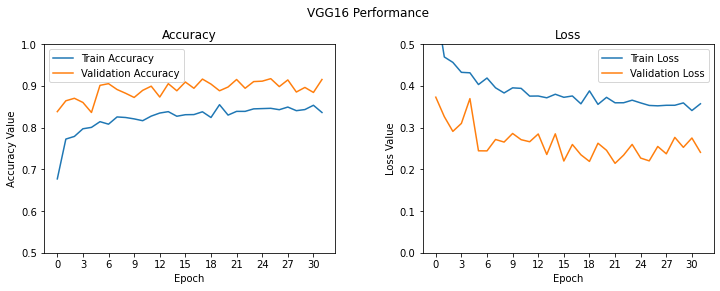

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG16 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
ax1.set_ylim((0.5,1))
ax2.set_ylim((0,0.5))

epoch_list = history.epoch
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 3))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 3))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [20]:
predict = model.predict(test_images, steps=50)
predict = np.round(predict)

              precision    recall  f1-score   support

         Cat       0.99      0.67      0.80      1833
         Dog       0.76      0.99      0.86      1916

    accuracy                           0.84      3749
   macro avg       0.87      0.83      0.83      3749
weighted avg       0.87      0.84      0.83      3749



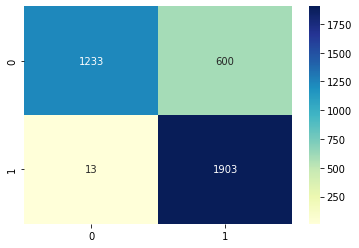

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

report = classification_report(test_labels, predict, target_names=['Cat', 'Dog'])
conf_mat = confusion_matrix(test_labels, predict)

print(report)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='YlGnBu')
plt.show()